## Diagnose K01 

w.r.t SAR wind speed amplitudes and asymmetries.

TODO: Maybe display the mean absolute error and standard deviation in a (r/Rmax, theta) plane? Also plot mean absolute errors and std on asym. amplitude and phase as a function of radius and outside Rmax.

TODO: Also diagnose the fully-fitted K01 model. Ideally it should show that K01-FIT is better in terms of wind speed retrievals. For such purpose, re-code FIT_K01 and save the netcdf files.

TODO: Also diagnose w.r.t the Ku-band scatterometer two-dimensional and average inflow angle (and perhaps its asymmetry?).

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth':     '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir':     '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
    'K01_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
}

# PRMS = {
#     'sav_fgs': True,
#     'sav_css': True,
# }

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

640


In [4]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., -2 * np.pi, 0.1], [upper_bound, 2 * np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette      = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [5]:
### FUNCTIONS TO COMPUTE ASYMMETRY AMPLITUDE
### FITS HOLLAND AT EACH RADIUS

def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

# Test - Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
# th_steps = np.linspace(0, 340, 341)
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [6]:
listOfWspds_dsp     = []
listOfWspds_dsk_prm = []


for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds      = dsg_filtered.isel(time=t)
    dsp     = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    dsk_prm = xr.open_dataset(PTHS['K01_PRM_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10, theta=slice(0, 359))

    # Append
    listOfWspds_dsp.append(np.array(dsp.wind_speed.transpose()).flatten())
    listOfWspds_dsk_prm.append(np.array(dsk_prm.wind_speed).flatten())

    # Close
    dsp.close()
    dsk_prm.close()

  0%|          | 0/640 [00:00<?, ?it/s]

In [7]:
wspds_dsp     = np.concatenate(listOfWspds_dsp)
wspds_dsk_prm = np.concatenate(listOfWspds_dsk_prm)

In [8]:
# plt.scatter(wspds_dsp, wspds_dsk_prm, c='gray', alpha=0.5)
# plt.plot()

In [9]:


# keep = (~np.isnan(wspds_dsp)) & (~np.isnan(wspds_dsk_prm))

# wspds_dsp_cleaned     = wspds_dsp[keep]
# wspds_dsk_prm_cleaned = wspds_dsk_prm[keep]

# kde_dsp     = gaussian_kde(wspds_dsp_cleaned)
# kde_dsk_prm = gaussian_kde(wspds_dsk_prm_cleaned)

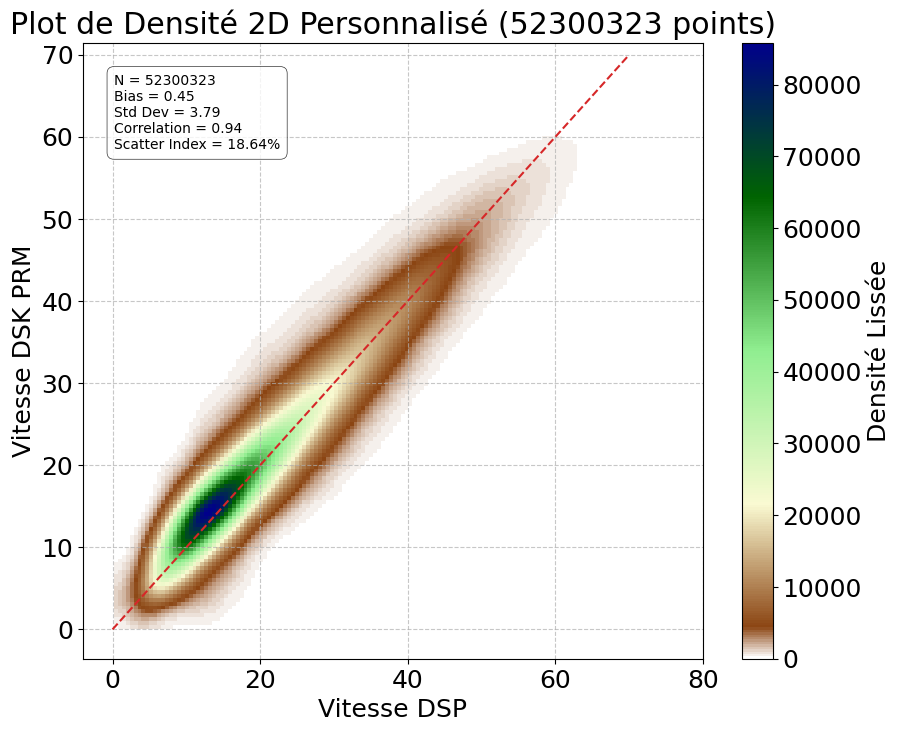

In [12]:
# --- Nettoyage des données ---
valid_mask = ~np.isnan(wspds_dsp) & ~np.isnan(wspds_dsk_prm)
wspds_dsp_cleaned = wspds_dsp[valid_mask]
wspds_dsk_prm_cleaned = wspds_dsk_prm[valid_mask]

if len(wspds_dsp_cleaned) == 0:
    print("Aucune donnée valide après le nettoyage des NaN.")
else:
    # --- Calcul de l'histogramme 2D (binning) ---
    num_bins = 150
    H, xedges, yedges = np.histogram2d(
        wspds_dsp_cleaned,
        wspds_dsk_prm_cleaned,
        bins=num_bins
    )

    sigma_smoothing = 2
    H_smoothed = gaussian_filter(H, sigma=sigma_smoothing)

    # --- Création de la colormap personnalisée ---
    colors = ["white",
              "saddlebrown",
              "lightgoldenrodyellow",
              "lightgreen",
              "darkgreen",
              "darkblue"]

    nodes = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
    custom_cmap = LinearSegmentedColormap.from_list("my_custom_cmap", list(zip(nodes, colors)))

    # --- Tracé de la heatmap de densité lissée avec la nouvelle colormap ---
    plt.figure(figsize=(10, 8))

    plt.imshow(H_smoothed.T,
               origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap=custom_cmap,
               aspect='auto')
    plt.plot([0, 70], [0, 70], c='tab:red', linestyle='dashed')

    cbar = plt.colorbar()
    cbar.set_label('Densité Lissée')

    plt.title(f'Plot de Densité 2D Personnalisé ({len(wspds_dsp_cleaned)} points)')
    plt.xlabel('Vitesse DSP')
    plt.ylabel('Vitesse DSK PRM')
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- Calcul des statistiques ---
    n_points = len(wspds_dsp_cleaned)
    if n_points > 1:
        differences = wspds_dsk_prm_cleaned - wspds_dsp_cleaned
        bias = np.mean(differences)
        std_dev = np.std(differences)
        correlation = np.corrcoef(wspds_dsp_cleaned, wspds_dsk_prm_cleaned)[0, 1]

        mean_dsp = np.mean(wspds_dsp_cleaned)
        if mean_dsp != 0:
            scatter_index = (std_dev / mean_dsp) * 100
        else:
            scatter_index = np.nan

        stats_text = (f"N = {n_points}\n"
                      f"Bias = {bias:.2f}\n"
                      f"Std Dev = {std_dev:.2f}\n"
                      f"Correlation = {correlation:.2f}\n"
                      f"Scatter Index = {scatter_index:.2f}%")

        # --- Modification pour placer l'encart en haut à gauche ---
        plt.text(0.05, 0.95, stats_text, # Changement des coordonnées x
                 transform=plt.gca().transAxes,
                 fontsize=10,
                 verticalalignment='top',
                 horizontalalignment='left', # Changement de l'alignement horizontal
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='black', lw=0.5))
    else:
        print("Pas assez de points pour calculer les statistiques.")

    plt.show()

In [11]:
# Avant d'afficher les informations, nous devons les calculer à partir de vos données nettoyées (wspds_dsp_cleaned et wspds_dsk_prm_cleaned).

# Bias (Biais): C'est une mesure de l'erreur systématique. On peut le calculer comme la différence moyenne entre les deux séries de vitesses. Par exemple, mean(wspds_dsk_prm_cleaned - wspds_dsp_cleaned).

# Standard Deviation (Écart-type): L'écart-type de la différence entre les deux séries. C'est une mesure de la dispersion de cette différence. std(wspds_dsk_prm_cleaned - wspds_dsp_cleaned).

# Correlation (Corrélation): Le coefficient de corrélation de Pearson entre les deux séries de vitesses. Il indique la force et la direction de la relation linéaire. np.corrcoef(wspds_dsp_cleaned, wspds_dsk_prm_cleaned)[0, 1].

# Scatter Index (SI): Souvent utilisé pour évaluer la performance d'un modèle. Il est défini comme l'écart-type des différences divisé par la moyenne des observations (souvent la moyenne du premier dataset ou la moyenne globale). std(diff) / mean(wspds_dsp_cleaned).

# Number of Points (N): Le nombre de paires de points valides utilisées après le nettoyage. len(wspds_dsp_cleaned).

In [ ]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds  = dsg_filtered.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    dsk_prm = xr.open_dataset(PTHS['K01_PRM_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10)






    
        #################
        ### SAR asym. ###
        #################
        # Initialize
        LWS = [] # To save the Holland wind speeds
        ERR = [] # To compute RMSE
        ACN = [] # Amplitude of cosine
        PHS = [] # Phase of cosine
        VTS = [] # Nb of valid thetas
    
        # Fit Holland for each theta
        for th in th_steps:
            ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
            wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
            r_crop, spdm_crop = initialize_radius(np.array(wsm))
        
            try:
                # Holland
                popt, pcov = curve_fit(
                    lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, lat, B, Vmin, Rmax, Vmax), 
                    np.array(r_crop), 
                    np.array(spdm_crop), 
                    p0=[1.8, 5, 20 * 1000, 40], 
                    bounds=(
                        tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                        tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
                    ) 
                ) 
                B_hol, vmn_hol, rmx_hol, vmx_hol = popt
                
            except RuntimeError:
                B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
            
            # Append
            LWS.append(holland_profile(rs, lat, B_hol, vmn_hol, rmx_hol, vmx_hol))
    
        # Create dataset with Holland for each theta
        dsh = xr.Dataset(
            data_vars={
                'ws':        (('th', 'rad'), LWS),
            },
            coords={
                'th': th_steps,
                'rad': rs,
            }
        )
        
        # Compute asymmetries
        for rad in xs:
            # Amplitude of cosine
            if np.count_nonzero(np.isnan(dsh.sel(rad=rad, method='nearest').ws)) == 0:
                acn, phi, c = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds.vmx) / 3, float(ds.vmx))
            else:
                acn = phi = c = np.nan
            ACN.append(acn)
            PHS.append(phi)
            # Error
            error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
            ERR.append(error)
            # Valid thetas
            VTS.append(len(dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))
    
        ### Validation metrics
        # Asymmetry amplitude metrics
        ds['max_asym_sar']  = np.nanmax(np.array(ACN)[xs >= rmx])
        ds['max_asym_K01']  = np.nanmax(np.array(aks)[xs >= rmx])
        ds['asym_avg_err']  = rmse(np.array(aks)[xs >= rmx], np.array(ACN)[xs >= rmx])
        # Asymmetry phase metrics
        a_sar               = (np.rad2deg(PHS) % 360)[xs >= rmx]
        a_K01               = (np.rad2deg(pks) % 360)[xs >= rmx]
        ds['phase_avg_err'] = np.nanmean(np.minimum(abs(a_sar - a_K01), 360 - abs(a_sar - a_K01)))
    
        ############
        ### Plot ###
        ############
        if PRMS['sav_fgs']:
            fig          = plt.figure(figsize=(20, 20))
            gs           = GridSpec(4, 2, hspace=0.24, wspace=0.21)
            cmap         = plt.get_cmap('PuOr') # Spectral
            normalizer   = Normalize(0, 80)
            ax_lims      = 250
            ts           = pd.to_datetime(str(ds.time.values)) 
            d            = ts.strftime('%Y-%m-%d, %H:%M')
            plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)
            
            ### Plot SAR
            ax           = fig.add_subplot(gs[0, :])
            dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
            ds_x, ds_y   = pol2cart(dr, th)
            ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
            im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)
            
            # Axes
            ax.set_xlim(-ax_lims, ax_lims);ax.set_ylim(-ax_lims, ax_lims)
            ax.set_ylabel(r'Distance from TC center (km)')
            ax.set_xlabel(r'Distance from TC center (km)')
            # ax.set_box_aspect(1)
            ax.minorticks_on()
            ax.tick_params(length=7, width=1.2)
            ax.grid()
            
            ax2 = ax.twinx().twiny() 
            ax2.set_xlim(-ax_lims, ax_lims);ax2.set_ylim(-ax_lims, ax_lims)
            ax2.minorticks_on()
            ax2.tick_params(axis='both', length=7, width=1.2)
            ax2.set_box_aspect(1)
            ax2.set_yticklabels([])
            ax2.set_xticklabels([])
            
            # Colorbar
            cb_ax = fig.add_axes([0.6, 0.717, 0.014, 0.163])
            cbar  = fig.colorbar(im, cax=cb_ax)
            cbar.set_label(r'Wind speed (m/s)', rotation=90)
            cbar.ax.get_yaxis().labelpad=5
            
            ### Plot wind field SAR
            ax       = fig.add_subplot(gs[1, 0])
            ax.pcolormesh(dsp.wind_speed.transpose(), cmap=cwnd, norm=normalizer)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Azimuth (deg)')
            ax.set_xlim(0, ax_lims)
            
            ### Plot wind field Kepert
            ax       = fig.add_subplot(gs[1, 1])
            ax.pcolormesh(Rs[0, :, :] / 1000, np.rad2deg(THs[0, :, :]), kep_pol.sel(z=10).wind_speed, cmap=cwnd, norm=normalizer)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Azimuth (deg)')
            ax.set_xlim(0, ax_lims)
            
            ### Plot wind profiles (SAR + Kepert)
            ax       = fig.add_subplot(gs[2, 0])
            ax.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
            ax.plot(rs / 1000,  Vs[0, 0, :], c='k', linewidth=3, label='SAR (Holland fit)')
            ax.plot(dsp.rad / 1000, dsp.wind_speed.mean(dim='theta'), c='k', linestyle='dashed', label='SAR (Obs)')
            ax.legend(frameon=False)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Wind speed (m/s)')
            ax.set_xlim(0, ax_lims)
            ax.grid()
            
            ### Plot conditional curves to highlight non-C1 points
            ax       = fig.add_subplot(gs[2, 1])
            ax.plot(rs / 1000, I__V_r, c='k', linewidth=3)
            ax.axhline(0, c='gray', linewidth=3)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'I - V/r (s-1)')
            ax.set_xlim(0, ax_lims)
            ax.set_ylim(-0.00001, 0.0002)
            ax.grid()
            
            ### Plot asymmetries (SAR + Kepert)
            ax       = fig.add_subplot(gs[3, 0])
            
            ax.plot(xs / 1000, ACN, c='k', linewidth=3,                 label='Amplitude of cosine to Holland fit')
            ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
            # Kepert asymmetry profiles
            ax.plot(xs / 1000, aks,                 c='tab:red',                        label='Model')
            # Wind radii
            ax.axvline(ds.rmx / 1000,                      c='k',    linewidth=3,        label='Rmax')
            ax.axvline(ds.rps / 1000,                      c='k',                        label='R+')
            ax.axvline(ds.r0 / 1000,                       c='k',    linestyle='dashed', label='R0')
            
            # Validity curves
            ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
            # ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
            ax.axhline(1, c='gray', alpha=0.3)
            
            # Legends
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel('Asym. WN1 amp. (m/s)')
            ax.legend(loc='lower center', bbox_to_anchor=(1.06, -0.62), ncol=3, fancybox=True, shadow=True)
            # ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
            ax.set_xlim(0, ax_lims)
            ax.set_ylim(0, 0.2 + float(np.nanmax([max(ACN), max(ERR), np.nanmax(aks)])))
            ax.grid()
            
            ### Phase of max. asymmetry
            ax       = fig.add_subplot(gs[3, 1])
            ax.plot(xs / 1000,  np.rad2deg(pks) % 360, c='tab:red', label='Model')
            ax.plot(xs / 1000,  np.rad2deg(PHS) % 360, c='k', linewidth=3, label='SAR')
            ax.axvline(ds.rmx / 1000,    c='k', linewidth=3)
            ax.axvline(ds.rps / 1000,    c='k')
            ax.axvline(ds.r0  / 1000,    c='k', linestyle='dashed')
            # ax.legend(frameon=False)
            ax.set_xlabel(r'Distance from TC center (km)')
            ax.set_ylabel(r'Phase of max. asym. (deg)')
            ax.set_xlim(0, ax_lims)
            ax.grid()
    
            # Save
            plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()
    
        # Concatenate
        listOfDatasets.append(ds)                   # Append to list of xarray.Dataset
    
        # Close
        dsp.close()
    
        # Save cases
        if PRMS['sav_fgs']:
            kep_pol['cd_mean_lp'] = cd_mean_lp
            kep_pol['K_mean_kpp'] = K_mean_kpp
            kep_pol.to_netcdf(PTHS['sav_dir'] + 'cases/{}.nc'.format(ds.file_tcva.item()[:-17]))

# Concatenate
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
new_dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

  0%|          | 0/640 [00:00<?, ?it/s]

/tmp/ipykernel_18695/1120526251.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig          = plt.figure(figsize=(20, 20))
/tmp/ipykernel_18695/1120526251.py:150: RuntimeWarning: All-NaN slice encountered
  ds['max_asym_sar']  = np.nanmax(np.array(ACN)[xs >= rmx])
/tmp/ipykernel_18695/1120526251.py:156: RuntimeWarning: Mean of empty slice
  ds['phase_avg_err'] = np.nanmean(np.minimum(abs(a_sar - a_K01), 360 - abs(a_sar - a_K01)))
/tmp/ipykernel_18695/1120526251.py:150: RuntimeWarning: All-NaN slice encountered
  ds['max_asym_sar']  = np.nanmax(np.array(ACN)[xs >= rmx])
/tmp/ipykernel_18695/1120526251.py:156: RuntimeWarning: Mean of empty slice
  ds['phase_avg_err'] = np.nanmean(np.minimum(abs(a_sar - a_K01), 360 - 

In [ ]:
# ### SAVE
# new_dsg.to_netcdf(PTHS['sav_dir'] + 'dsg_dummy{}.nc'.format(fixed_K))